In [9]:
!pip install gluonnlp
!pip install mxnet
!pip install kobert

     |████████████████████████████████| 47.3 MB 1.4 MB/s 
  Attempting uninstall: graphviz
    Found existing installation: graphviz 0.10.1
    Uninstalling graphviz-0.10.1:
      Successfully uninstalled graphviz-0.10.1
ERROR: Could not find a version that satisfies the requirement kobert (from versions: none)
ERROR: No matching distribution found for kobert


In [13]:
!pip install sentencepiece

In [11]:
!pip install mxnet-cu101
!pip install sentencepiece==0.1.85
!pip install transformers==2.1.1
!pip install git+https://git@github.com/SKTBrain/KoBERT.git@master


Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/pip/_internal/cli/base_command.py", line 180, in _main
    status = self.run(options, args)
  File "/usr/local/lib/python3.7/dist-packages/pip/_internal/cli/req_command.py", line 199, in wrapper
    return func(self, options, args)
  File "/usr/local/lib/python3.7/dist-packages/pip/_internal/commands/install.py", line 319, in run
    reqs, check_supported_wheels=not options.target_dir
  File "/usr/local/lib/python3.7/dist-packages/pip/_internal/resolution/resolvelib/resolver.py", line 128, in resolve
    requirements, max_rounds=try_to_avoid_resolution_too_deep
  File "/usr/local/lib/python3.7/dist-packages/pip/_vendor/resolvelib/resolvers.py", line 473, in resolve
    state = resolution.resolve(requirements, max_rounds=max_rounds)
  File "/usr/local/lib/python3.7/dist-packages/pip/_vendor/resolvelib/resolvers.py", line 341, in resolve
    name, crit = self._merge_into_criterion(r, parent=None)
  File "/

     |████████████████████████████████| 734.6 MB 18 kB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.10.0+cu111
    Uninstalling torch-1.10.0+cu111:


      Successfully uninstalled torch-1.10.0+cu111
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchvision 0.11.1+cu111 requires torch==1.10.0, but you have torch 1.3.1 which is incompatible.
torchtext 0.11.0 requires torch==1.10.0, but you have torch 1.3.1 which is incompatible.
torchaudio 0.10.0+cu111 requires torch==1.10.0, but you have torch 1.3.1 which is incompatible.


  Cloning https://****@github.com/SKTBrain/KoBERT.git (to revision master) to /tmp/pip-req-build-m4tu0f54
  Running command git clone -q 'https://****@github.com/SKTBrain/KoBERT.git' /tmp/pip-req-build-m4tu0f54
     |████████████████████████████████| 4.5 MB 5.3 MB/s 
     |██████████████████████████████▎ | 834.1 MB 38.4 MB/s eta 0:00:02tcmalloc: large alloc 1147494400 bytes == 0x55b36a1fa000 @  0x7f8f34b69615 0x55b330a153bc 0x55b330af618a 0x55b330a181cd 0x55b330b0ab3d 0x55b330a8c458 0x55b330a8702f 0x55b330a19aba 0x55b330a8c2c0 0x55b330a8702f 0x55b330a19aba 0x55b330a88cd4 0x55b330b0b986 0x55b330a88350 0x55b330b0b986 0x55b330a88350 0x55b330b0b986 0x55b330a88350 0x55b330a19f19 0x55b330a5da79 0x55b330a18b32 0x55b330a8c1dd 0x55b330a8702f 0x55b330a19aba 0x55b330a88cd4 0x55b330a8702f 0x55b330a19aba 0x55b330a87eae 0x55b330a199da 0x55b330a88108 0x55b330a8702f
     |████████████████████████████████| 881.9 MB 2.0 kB/s 
     |████████████████████████████████| 3.5 MB 32.8 MB/s 
     |██████████████

In [1]:
import pandas as pd
from glob import glob
import os
import numpy as np
from tqdm import tqdm, tqdm_notebook

import torch
from torch import nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import gluonnlp as nlp
from kobert.utils import get_tokenizer
from kobert.pytorch_kobert import get_pytorch_kobert_model
from transformers import AdamW

#### Kobert Baseline
kobert : BERT 모델에서 한국어 데이터를 추가로 학습시킨 모델

BERT는 Transformer라는 모델의 인코더 구조를 여러층으로 쌓은 형태의 구조를 가짐

Transformer 모델의 구조 

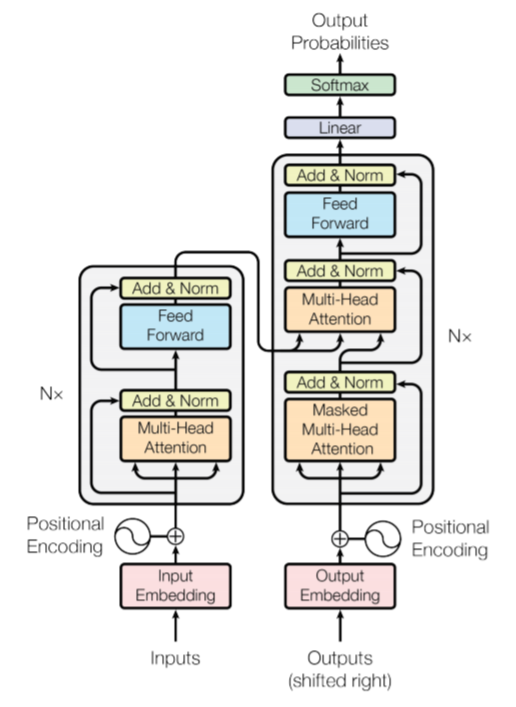

nlp 분야에서 자주 쓰이는 모델 : Transformer, Bert, GPT-3

In [2]:
train = pd.read_csv('/content/drive/MyDrive/한국어 분류/train_data.csv')
test = pd.read_csv('/content/drive/MyDrive/한국어 분류/test_data.csv')
submission = pd.read_csv('/content/drive/MyDrive/한국어 분류/sample_submission.csv')

In [7]:
train.head(5)

,index,premise,hypothesis,label
0,0,"씨름은 상고시대로부터 전해져 내려오는 남자들의 대표적인 놀이로서, 소년이나 장정들이...",씨름의 여자들의 놀이이다.,contradiction
1,1,"삼성은 자작극을 벌인 2명에게 형사 고소 등의 법적 대응을 검토 중이라고 하였으나,...",자작극을 벌인 이는 3명이다.,contradiction
2,2,이를 위해 예측적 범죄예방 시스템을 구축하고 고도화한다.,예측적 범죄예방 시스템 구축하고 고도화하는 것은 목적이 있기 때문이다.,entailment
3,3,광주광역시가 재개발 정비사업 원주민들에 대한 종합대책을 마련하는 등 원주민 보호에 ...,원주민들은 종합대책에 만족했다.,neutral
4,4,"진정 소비자와 직원들에게 사랑 받는 기업으로 오래 지속되고 싶으면, 이런 상황에서는...",이런 상황에서 책임 있는 모습을 보여주는 기업은 아주 드물다.,neutral


In [6]:
print(train['label'].unique())

['contradiction' 'entailment' 'neutral']


In [15]:
max_len = 70
batch_size = 128
warmup_ratio = 0.1
num_epochs = 5
max_grad_norm = 1
log_interval = 200
learning_rate = 5e-5

device = torch.device("cuda:0")

In [4]:
bertmodel, vocab = get_pytorch_kobert_model(cachedir = ".cache")

tokenizer = get_tokenizer()
tok = nlp.data.BERTSPTokenizer(tokenizer, vocab, lower=False)

/content/.cache/kobert_v1.zip[██████████████████████████████████████████████████]
/content/.cache/kobert_news_wiki_ko_cased-1087f8699e.spiece[██████████████████████████████████████████████████]
using cached model. /content/.cache/kobert_news_wiki_ko_cased-1087f8699e.spiece


In [9]:
class BERTDataset(Dataset):
    def __init__(self, dataset, sent_idx, label_idx, bert_tokenizer, max_len,
                pad, pair, mode = "train"):
        self.mode = mode
        transform = nlp.data.BERTSentenceTransform(bert_tokenizer, max_seq_length = max_len, pad = pad, pair = pair)
        if self.mode == "train":
            self.sentences = [transform([i[sent_idx]]) for i in dataset]
            self.labels = [np.int32(i[label_idx]) for i in dataset]
            
        else:
            self.sentences = [transform(i) for i in dataset]
        
    def __getitem__(self, i):
        if self.mode == 'train':
            return (self.sentences[i] + (self.labels[i], ))
        else:
            return self.sentences[i]
    
    def __len__(self):
        return (len(self.sentences))

문장을 표현할 때 세가지 임베딩 사용 : **Token, segment, position**

*Token* Embedding에서 두 가지 특수 토큰(CLS, SEP)을 사용해서 문장을 구별함.

**CLS(special classification token)** : 모든 문장의 가장 첫번째(문장의 시작) 토큰으로 삽입된다. classification 문제일 때만 사용됨

**SEP(special separator token)** : 첫번째 문장과 두번째 문장 구별함.* segment* embedding을 더해서 앞뒤 문장 더 쉽게 구별할 수 있도록. 각 문장의 끝에 삽입됨

*position* embedding은 토큰의 위치를 알려주는 임베딩

최종적으로 세가지 임베딩을 더한 임베딩을 input으로 사용하게 됨

In [13]:
label_dict = {"entailment" : 0, "contradiction" : 1, "neutral" : 2}

train["premise_"] = "[CLS]" + train["premise"] + "[SEP]"
train["hypothesis_"] = train["hypothesis"] + "[SEP]"

test["premise_"] = "[CLS]" + test["premise"] + "[SEP]"
test["hypothesis_"] = test["hypothesis"] + "[SEP]"

train["text_sum"] = train.premise_ + " " + train.hypothesis_
test["text_sum"] = test.premise_ + " " + test.hypothesis_

train_content = []
test_content = []

for i, text in enumerate(train.text_sum):
    train_content.append(list([text, str(label_dict[train.label[i]])]))
    
for i, text in enumerate(test.text_sum):
    test_content.append([text])
    
dataset_train = train_content[:20000]
dataset_valid = train_content[20000:]
dataset_test = test_content

data_train = BERTDataset(dataset_train, 0, 1, tok, max_len, True, False, mode = "train")
data_valid = BERTDataset(dataset_valid, 0, 1, tok, max_len, True, False, mode = "train")
data_test = BERTDataset(dataset_test, 0, 1, tok, max_len, True, False, mode = "test")

train_dataloader = torch.utils.data.DataLoader(data_train, batch_size = batch_size, num_workers = 5)
valid_dataloader = torch.utils.data.DataLoader(data_valid, batch_size = batch_size, num_workers = 5)
test_dataloader = torch.utils.data.DataLoader(data_test, batch_size = batch_size, num_workers = 5)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [8]:
# BERT 튜토리얼에 있는 내용 
# 이중분류면 num_classes=2, 다중분류면 num_classes = n

class BERTClassifier(nn.Module):
    def __init__(self, bert, hidden_size = 768, num_classes=3, dr_rate=None, params=None):
        super(BERTClassifier, self).__init__()
        self.bert = bert
        self.dr_rate = dr_rate
                 
        self.classifier = nn.Linear(hidden_size , num_classes)
        if dr_rate:
            self.dropout = nn.Dropout(p=dr_rate)
    
    def gen_attention_mask(self, token_ids, valid_length):
        attention_mask = torch.zeros_like(token_ids)
        for i, v in enumerate(valid_length):
            attention_mask[i][:v] = 1
        return attention_mask.float()

    def forward(self, token_ids, valid_length, segment_ids):
        attention_mask = self.gen_attention_mask(token_ids, valid_length)
        
        _, pooler = self.bert(input_ids = token_ids, token_type_ids = segment_ids.long(), attention_mask = attention_mask.float().to(token_ids.device))
        if self.dr_rate:
            out = self.dropout(pooler)
        return self.classifier(out)

In [10]:
model = BERTClassifier(bertmodel, dr_rate = 0.5).to(device)

no_decay = ['bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
    {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
]

optimizer = AdamW(optimizer_grouped_parameters, lr=learning_rate)
loss_fn = nn.CrossEntropyLoss()

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use thePyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


In [11]:
def calc_accuracy(X,Y):
    max_vals, max_indices = torch.max(X, 1)
    train_acc = (max_indices == Y).sum().data.cpu().numpy()/max_indices.size()[0]
    return train_acc

In [16]:
for e in range(num_epochs):
    train_acc = 0.0
    valid_acc = 0.0
    model.train()
    for batch_id, (token_ids, valid_length, segment_ids, label) in tqdm(enumerate(train_dataloader), total=len(train_dataloader)):
        optimizer.zero_grad()
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length= valid_length
        label = label.long().to(device)
        out = model(token_ids, valid_length, segment_ids)
        loss = loss_fn(out, label)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
        #clip_grad_norm_ : Gradient Clipping 학습 중 gradient vanishing 혹은 exploding이 발생하는 것을 방지하여 학습을 안정화시키기 위함
        # gradient의 최대 갯수를 제한하고, gradient가 최대치를 넘게되면 gradient의 크기를 재조정해서 gradient의 크기를 조정하는 것 -> 업데이트 되어야하는 step의 크기(learning rate)를 자동으로 조정함
        optimizer.step()
        train_acc += calc_accuracy(out, label)

    print("epoch {} train acc {}".format(e+1, train_acc / (batch_id+1)))
    model.eval()
    for batch_id, (token_ids, valid_length, segment_ids, label) in tqdm(enumerate(valid_dataloader), total=len(valid_dataloader)):
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length= valid_length
        label = label.long().to(device)
        out = model(token_ids, valid_length, segment_ids)
        valid_acc += calc_accuracy(out, label)
    print("epoch {} valid acc {}".format(e+1, valid_acc / (batch_id+1)))

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
100%|██████████| 157/157 [07:21<00:00,  2.81s/it]

epoch 1 train acc 0.36549562101910826



  2%|▎         | 1/40 [00:01<01:04,  1.65s/it]


RuntimeError: ignored